In [1]:
%run ct_include.ipy
source.name
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydicom

In [3]:
def read_dcm(folder_name):
    # return 3d array of hu unit, pixelspacing and slice thickness
    root = os.getcwd()
    folder_path = os.path.join(root, folder_name)
    fnames = []


    for file in os.listdir(folder_path):
        if file.endswith(".dcm"): 
            fname = os.path.join(folder_path, file)
            fnames.append(fname)
      

    # load the DICOM files
    files = []

    #print('glob: {}'.format(sys.argv[1]))
    for fname in fnames:
        #print("loading: {}".format(fname))
        files.append(pydicom.dcmread(fname))

    #print("file count: {}".format(len(files)))

    # skip files with no SliceLocation (eg scout views)
    slices = []
    skipcount = 0
    for f in files:
        if hasattr(f, 'SliceLocation'):
            slices.append(f)    # slices contain all files with this attr
        else:
            skipcount = skipcount + 1

    #print("skipped, no SliceLocation: {}".format(skipcount))

    # ensure they are in the correct order
    slices = sorted(slices, key=lambda s: s.SliceLocation)

    # pixel aspects, assuming all slices are the same
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness


    # create 3D array
    img_shape = list(slices[0].pixel_array.shape)   # shape of one slice
    img_shape.append(len(slices))    # shape of one slice * no of slice
    print('model shape: ', img_shape)
    img3d = np.zeros(img_shape)

    # fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = s.pixel_array
        img3d[:, :, i] = img2d


    return img3d, ps, ss

def plot_3d(img3d, ps, ss,):
    #
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]
    img_shape = img3d.shape
    plt.figure(figsize=(15, 15))
    
    # plot 3 orthogonal slices
    a1 = plt.subplot(2, 2, 1)
    plt.imshow(img3d[:, :, img_shape[2]//2])
    a1.set_aspect(ax_aspect)

    a2 = plt.subplot(2, 2, 2)
    plt.imshow(img3d[:, img_shape[1]//2, :])
    a2.set_aspect(sag_aspect)

    a3 = plt.subplot(2, 2, 3)
    plt.imshow(img3d[img_shape[0]//2, :, :].T)
    a3.set_aspect(cor_aspect)

    plt.colorbar()
    
    plt.show(a3)
    
    return None

def cylinder_crop(img3d, ratio = 0.9, cut = 2):
    # cut = 2 means img3d[:, :, xxx] xxx will be cropped
    if cut == 2:
        length, width = img3d.shape[0], img3d.shape[1]
    elif cut == 1:
        length, width = img3d.shape[0], img3d.shape[2]
    elif cut == 0:
        length, width = img3d.shape[1], img3d.shape[2]

    radius = int(min(length, width)/2 * ratio) # radius of cropped circle
    xi, yi = np.meshgrid(np.arange(0,length,1) - (length/2) + 0.5, np.arange(0,width,1) - (width/2) + 0.5)
    img3d[np.where((xi ** 2 + yi ** 2) > radius**2)] = -1000 # -1000 is HU of air
        
    return img3d

def straight_crop(img3d, ratio = 0.9, cut = 2):
    n = int(img3d.shape[cut]*(1-ratio))
    if cut == 2: 
        img3d[:, :, :n] = -1000
    elif cut == 1: 
        img3d[:, :n, :] = -1000
    elif cut == 0: 
        img3d[:n, :, :] = -1000

    return img3d

model shape:  [128, 128, 145]
(128, 128, 145)


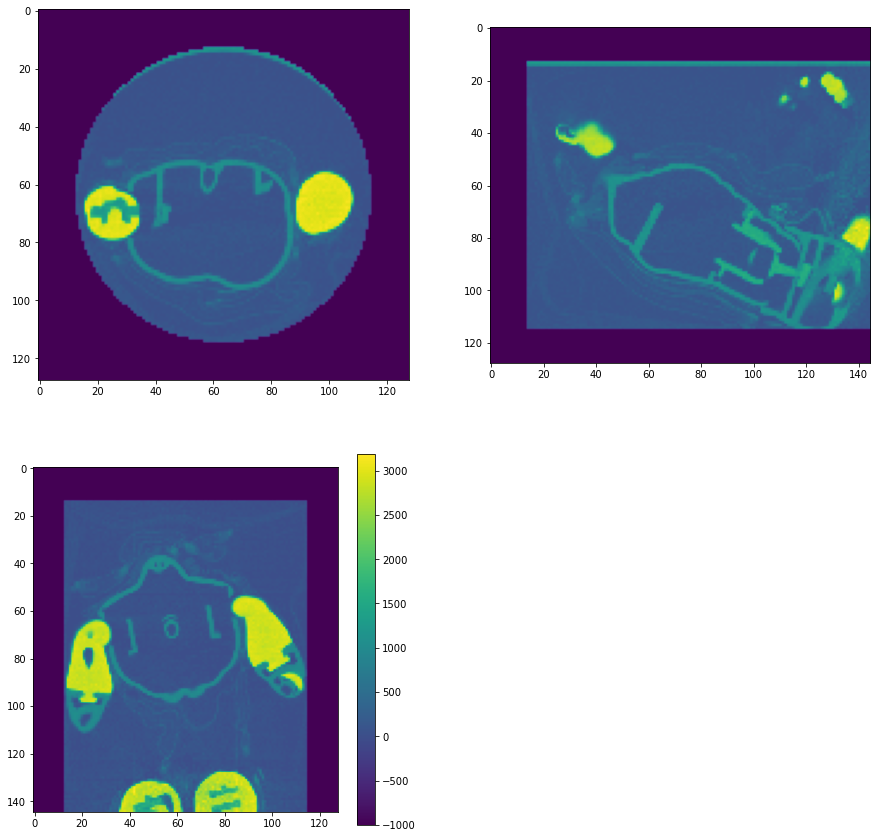

In [4]:
img3d, ps, ss = read_dcm('recon_data_a')
img3d = cylinder_crop(img3d, ratio = 0.8)
img3d = straight_crop(img3d, ratio = 0.9)
print(img3d.shape)
plot_3d(img3d, ps, ss,)

#print(img3d[:, :, img_shape[2]//2][50])

In [6]:

HOUNSFIELD_MIN = -1024
HOUNSFIELD_MAX = 4096
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN



model shape:  [128, 128, 145]


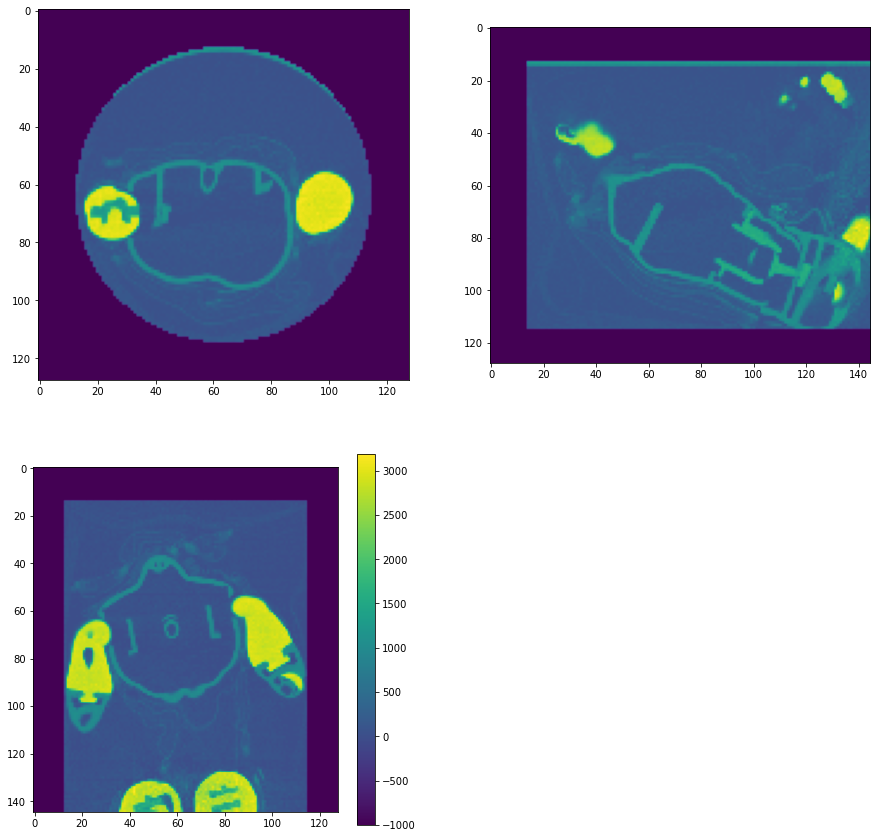

(-1000.0, 4096.0, (128, 128, 145), numpy.ndarray)

In [7]:
img3d, ps, ss = read_dcm('recon_data_a')
img3d = cylinder_crop(img3d, ratio = 0.8)
img3d = straight_crop(img3d, ratio = 0.9)
plot_3d(img3d, ps, ss,)
np.min(img3d), np.max(img3d), img3d.shape, type(img3d)

In [8]:
# normalise image
def normalise(img3d):
    img3d[img3d < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img3d[img3d > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img3d - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

img3d = normalise(img3d)
np.min(img3d), np.max(img3d), img3d.shape, type(img3d)

(0.0046875, 1.0, (128, 128, 145), numpy.ndarray)

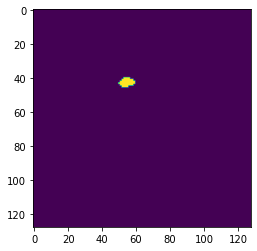

In [10]:

def generate_and_save_mask(img3d, mask_folder_path, img_folder_path):
    img_shape = img3d.shape
    x, y, z= img_shape
    mask3d = np.zeros(img_shape)
    threshold = 0.6
    for i in range(z):
        if i<= 58:
            slice = img3d[:, :, i]
            mask = slice > threshold
            mask[60:, 75:] = 0
            mask3d[:, :, i] = mask
        mask_fname = 'z_mask' + "{:03d}".format(i) + '.txt'
        img_fname = 'z_img' + "{:03d}".format(i) + '.txt'
        mask_save_path = os.path.join(mask_folder_path, mask_fname)
        img_save_path = os.path.join(img_folder_path, img_fname)
        np.savetxt(mask_save_path, mask, fmt='%d')
        np.savetxt(img_save_path, slice, fmt='%f')
    return mask3d


root = os.getcwd()
mask_folder_path = os.path.join(root, 'data\\train\\mask')
img_folder_path = os.path.join(root, 'data\\train\\image')

mask3d = generate_and_save_mask(img3d, mask_folder_path, img_folder_path)
plt.imshow(mask3d[: ,: , 56])

In [ ]:
from skimage.measure import marching_cubes_lewiner
import meshplot as mp
from stl import mesh

In [11]:
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict



In [12]:
# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_TEST = 16

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = 'data/'
data_dir_train = os.path.join(data_dir, 'train')
# The images should be stored under: "data/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'image')
# The images should be stored under: "data/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test')
# The images should be stored under: "data/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'image')
# The images should be stored under: "data/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 145
NUM_TEST = 128

NUM_OF_EPOCHS = 100

(128, 128)


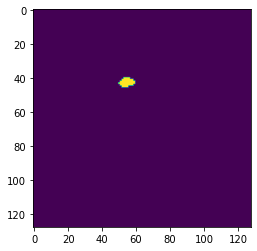

In [13]:
path = os.path.join(root, 'data\\train\\mask\\z_mask056.txt')
xxx = np.loadtxt(path)
plt.imshow(xxx)
print(xxx.shape)

mask_folder_path = os.path.join(root, 'data\\train\\mask')
image_folder_path = os.path.join(root, 'data\\train\\image')



In [14]:
class CTDataset(Dataset):
    def __init__(self, image_folderpath, mask_folderpath):
        self.image_folderpath = image_folderpath
        self.mask_folderpath = mask_folderpath

        image_paths = []
        mask_paths = []

        for image_filename in os.listdir(image_folderpath): 
            image_path = os.path.join(image_folderpath, image_filename)
            image_paths.append(image_path)

        for mask_filename in os.listdir(mask_folderpath): 
            mask_path = os.path.join(mask_folderpath, mask_filename)
            mask_paths.append(mask_path)

        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = np.loadtxt(image_filepath)

        mask_filepath = self.mask_paths[idx]
        mask = np.loadtxt(mask_filepath)
        
        return image, mask
    
def display(display_list):
    plt.figure(figsize=(10,10))
    title = ['Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
    plt.show()

def show_dataset(datagen, num=1):
    iteration = iter(datagen)
    for i in range(0,num):
        image, mask = next(iteration)[0], next(iteration)[1]
        display([image, mask])

In [160]:
CT_dataset = CTDataset(image_folder_path, mask_folder_path)
#print(next(iter(CT_dataset)))

# create dataloader
CT_DL = DataLoader(CT_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

#show_dataset(CT_dataset, 1)


In [163]:
class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=1):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


import torch.nn as nn


class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc